# Analyzing patient data (extended version)

Load the required modules.

In [77]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

Import the data set as a pandas `DataFrame` from an Excel spreadsheet.

In [78]:
data = pd.read_excel('data/patient_data.xlsx')

Let's explore the data set a bit.

In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 6 columns):
patient        62 non-null int64
dose           61 non-null float64
date           62 non-null datetime64[ns]
temperature    61 non-null float64
gender         62 non-null object
condition      62 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 3.0+ KB


`data` contains 6 columns, and 62 rows, and there seems to be missing data for `dose` since that column has only 61 entries.

Let's check the first few and last few rows.

In [80]:
data.head()

,patient,dose,date,temperature,gender,condition
0,1,0.0,2012-10-02 10:00:00,38.3,M,A
1,1,2.0,2012-10-02 11:00:00,38.5,M,A
2,1,2.0,2012-10-02 12:00:00,38.1,M,A
3,1,2.0,2012-10-02 13:00:00,37.3,M,A
4,1,0.0,2012-10-02 14:00:00,37.5,M,A


In [81]:
data.tail()

,patient,dose,date,temperature,gender,condition
57,9,12.0,2012-10-02 12:00:00,40.2,M,B
58,9,4.0,2012-10-02 13:00:00,39.1,M,B
59,9,4.0,2012-10-02 14:00:00,37.9,M,B
60,9,0.0,2012-10-02 15:00:00,37.1,M,B
61,9,0.0,2012-10-02 16:00:00,37.3,M,B


A very rough statistical overview is also useful.

In [82]:
data.describe()

,patient,dose,temperature
count,62.000000,61.000000,61.000000
mean,4.983871,2.278689,37.881967
std,2.620799,2.989599,1.081127
min,1.000000,0.000000,35.900000
25%,3.000000,0.000000,37.100000
50%,5.000000,1.000000,37.700000
75%,7.000000,4.000000,38.300000
max,9.000000,12.000000,40.700000


It seems as if we have 9 patients, but lets verify that.

In [83]:
patients = data['patient'].drop_duplicates().values
print(patients, '->', len(patients))

[1 2 3 4 5 6 7 8 9] -> 9



How many distinct genders and conditions do we have?

In [84]:
for column in ['gender' ,'condition']:
    values = data[column].drop_duplicates().values
    print(column, ':', values, '->', len(values))

gender : ['M' 'F'] -> 2
condition : ['A' 'B' 'C'] -> 3


There are two genders, male and female, and three categories, A, B, and C. Since this is categorical data, it would make sense to convert those columns to that type.

In [85]:
data['gender'] = data.gender.astype('category')
data['condition'] = data.condition.astype('category')

In [86]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 6 columns):
patient        62 non-null int64
dose           61 non-null float64
date           62 non-null datetime64[ns]
temperature    61 non-null float64
gender         62 non-null category
condition      62 non-null category
dtypes: category(2), datetime64[ns](1), float64(2), int64(1)
memory usage: 2.3 KB


In [87]:
data[['gender', 'condition']].describe()

,gender,condition
count,62,62
unique,2,3
top,M,A
freq,35,35


How many patients are male, and how many female?

In [88]:
data[['patient', 'gender']].drop_duplicates() \
    .groupby('gender').count()

,patient
gender,
F,4
M,5


Let's compute the number of data points per patient.

In [89]:
data[['patient', 'date']].groupby('patient').count()

,date
patient,
1,7
2,7
3,7
4,7
5,7
6,6
7,7
8,7
9,7


For all patients but one there are 7 measurements, for one there are only six.

In [90]:
data.query('patient == 1')[['date']]

,date
0,2012-10-02 10:00:00
1,2012-10-02 11:00:00
2,2012-10-02 12:00:00
3,2012-10-02 13:00:00
4,2012-10-02 14:00:00
5,2012-10-02 15:00:00
6,2012-10-02 16:00:00


In [91]:
data.query('patient == 6')

,patient,dose,date,temperature,gender,condition
35,6,0.0,2012-10-02 10:00:00,37.5,F,B
36,6,2.0,2012-10-02 11:00:00,38.1,F,B
37,6,3.0,2012-10-02 12:00:00,37.9,F,B
38,6,2.0,2012-10-02 13:00:00,37.7,F,B
39,6,1.0,2012-10-02 14:00:00,37.2,F,B
40,6,0.0,2012-10-02 15:00:00,36.8,F,B


In order to perform some operations, such as a pivot table to turn this data into a time series, we need the same time stamps for all patients, so we simply add a row.

In [92]:
missing_row = pd.DataFrame([[6, pd.NaT,
                             pd.to_datetime('2012-10-02 16:00:00'),
                             pd.NaT,
                             'F', 'B',]],
                           columns=data.columns)
data = data.append(missing_row, ignore_index=True)

In [93]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 6 columns):
patient        63 non-null int64
dose           61 non-null float64
date           63 non-null datetime64[ns]
temperature    61 non-null float64
gender         63 non-null object
condition      63 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 3.0+ KB


In [94]:
time_series = data.pivot_table(index='date',
                               columns=('patient', ))

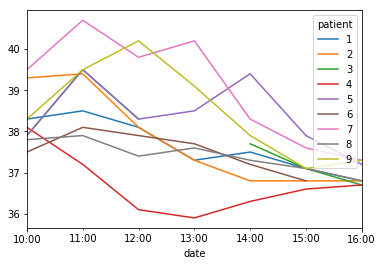

In [95]:
time_series.temperature.plot();

Hm, something seems fishy with the data for patient 3, let's visualize it individually.

In [96]:
def show_patient(time_series, patient):
    fig = plt.figure(figsize=(8.0, 4.0))
    axis1 = fig.add_subplot(1, 2, 1)
    for i, value_name in enumerate(['temperature', 'dose']):
        axis = fig.add_subplot(1, 2, 1 + i)
        axis.set_ylabel(value_name)
        axis.plot(time_series.index,
                  time_series[value_name, patient].values)
        axis.set_xticklabels(time_series.index, rotation=90)
    fig.tight_layout()
    plt.show();

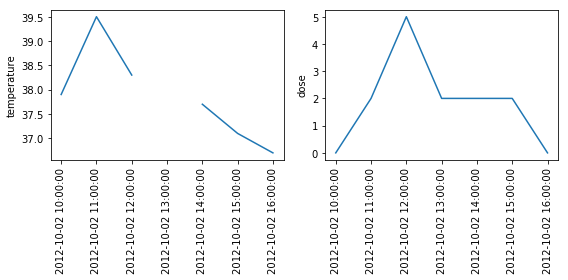

In [97]:
show_patient(time_series, 3)

The temperature for patient 3 was not measured at 13:00:00, but the dose was recorded. Let's check for other missing data more systematically.

In [98]:
time_series.isnull().any(axis=1)

date
2012-10-02 10:00:00    False
2012-10-02 11:00:00    False
2012-10-02 12:00:00    False
2012-10-02 13:00:00     True
2012-10-02 14:00:00     True
2012-10-02 15:00:00    False
2012-10-02 16:00:00     True
dtype: bool

We should take a look at the measurements for 13:00:00 and 14:00:00.

In [99]:
time_series.loc[pd.to_datetime('2012-10-02 13:00:00')]

             patient
dose         1           2.0
             2           5.0
             3           2.0
             4           0.0
             5           5.0
             6           2.0
             7           8.0
             8           0.0
             9           4.0
temperature  1          37.3
             2          37.3
             3           NaN
             4          35.9
             5          38.5
             6          37.7
             7          40.2
             8          37.6
             9          39.1
Name: 2012-10-02 13:00:00, dtype: float64

This was the temperature we were aware of, but at 14:00:00, it seems the dose was not recorded for patient 4.

In [100]:
time_series.loc[pd.to_datetime('2012-10-02 14:00:00')]

             patient
dose         1           0.0
             2           0.0
             3           2.0
             4           NaN
             5           9.0
             6           1.0
             7           3.0
             8           0.0
             9           4.0
temperature  1          37.5
             2          36.8
             3          37.7
             4          36.3
             5          39.4
             6          37.2
             7          38.3
             8          37.3
             9          37.9
Name: 2012-10-02 14:00:00, dtype: float64

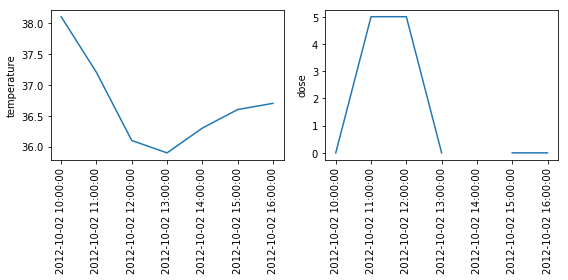

In [101]:
show_patient(time_series, 4)

From the plots, it seems reasonable to do a linear interpolation for both missing data points.

In [102]:
interpolated_3 = time_series.temperature[3].interpolate()
interpolated_4 = time_series.dose[4].interpolate()

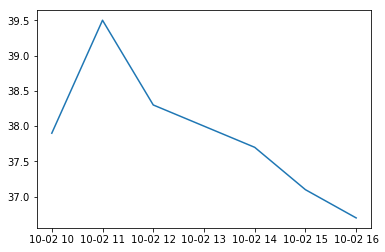

In [103]:
plt.plot(interpolated_3);

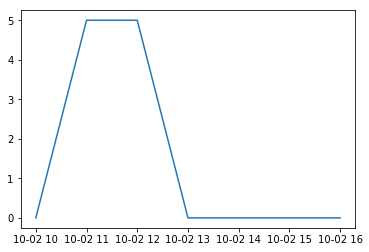

In [104]:
plt.plot(interpolated_4);

Let's do the interpolation on the time series in place.

In [105]:
time_series.interpolate(inplace=True)

We should have no more missing data, let's verify.

In [106]:
time_series.isnull().any(axis=1)

date
2012-10-02 10:00:00    False
2012-10-02 11:00:00    False
2012-10-02 12:00:00    False
2012-10-02 13:00:00    False
2012-10-02 14:00:00    False
2012-10-02 15:00:00    False
2012-10-02 16:00:00    False
dtype: bool

Let's add a new column to the time series that represents the average temperature over all patients.

In [107]:
time_series['avg_temp'] = time_series.temperature.mean(axis=1)

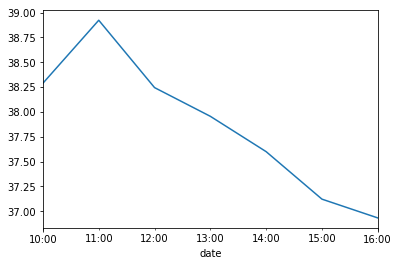

In [108]:
time_series.avg_temp.plot();

Let's also add a column for each patient that shows the cummulative dose for that patient.

In [109]:
for patient in time_series.dose.columns:
    cumm_dose = time_series['dose', patient].cumsum()
    time_series['cumm_dose', patient] = cumm_dose

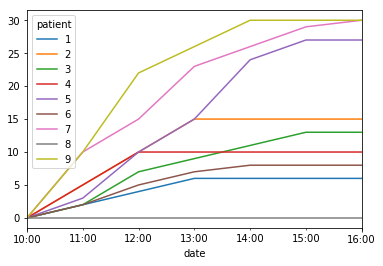

In [110]:
time_series.cumm_dose.plot();

Let's check the maximum temperature and the total dose per patient using a pivot table.

In [111]:
hypothesis = data.pivot_table(index='patient',
                              values=('dose', 'temperature',),
                              aggfunc={
                                  'dose': np.sum,
                                  'temperature': np.max,
                              })
hypothesis

,dose,temperature
patient,,
1,6.0,38.5
2,15.0,39.4
3,13.0,39.5
4,10.0,38.1
5,27.0,39.5
6,8.0,38.1
7,30.0,40.7
8,0.0,37.9
9,30.0,40.2


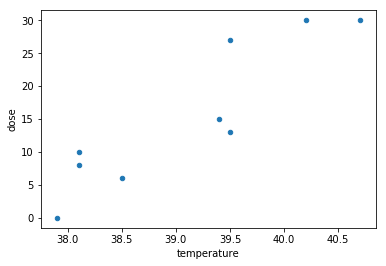

In [112]:
hypothesis.plot.scatter(x='temperature', y='dose',
                        marker='o');

Which patients had a temperature higher than $39^{\circ}$, and when?  Let's also display the gender.

In [113]:
data[['patient', 'date', 'temperature', 'gender']] \
    .query('temperature > 39.5')

,patient,date,temperature,gender
42,7,2012-10-02 11:00:00,40.7,M
43,7,2012-10-02 12:00:00,39.8,M
44,7,2012-10-02 13:00:00,40.2,M
57,9,2012-10-02 12:00:00,40.2,M


Suspiciously many males, let's see how many males versus females had a temperature (at any point).

In [114]:
data.query('temperature > 39.0')[['patient', 'gender']] \
    .drop_duplicates().groupby('gender').count()

,patient
gender,
F,1
M,4


There might be a gender influence here. Let's split our data set into male and female patients.

In [115]:
gender_series = data.pivot_table(index='date',
                                 columns=('gender', 'patient', ))
gender_series.interpolate(inplace=True)
gender_series

dose                                            \
gender                 F                   M                         
patient                2    4    6    8    1    3    5     7     9   
date                                                                 
2012-10-02 10:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   
2012-10-02 11:00:00  5.0  5.0  2.0  0.0  2.0  2.0  3.0  10.0  10.0   
2012-10-02 12:00:00  5.0  5.0  3.0  0.0  2.0  5.0  7.0   5.0  12.0   
2012-10-02 13:00:00  5.0  0.0  2.0  0.0  2.0  2.0  5.0   8.0   4.0   
2012-10-02 14:00:00  0.0  0.0  1.0  0.0  0.0  2.0  9.0   3.0   4.0   
2012-10-02 15:00:00  0.0  0.0  0.0  0.0  0.0  2.0  3.0   3.0   0.0   
2012-10-02 16:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0   1.0   0.0   

                    temperature                                            \
gender                        F                       M                     
patient                       2     4     6     8     1     3     5     7   
date                                                                        
2012-10-02 10:00:00        39.3  38.1  37.5  37.8  38.3  37.9  37.9  39.5   
2012-10-02 11:00:00        39.4  37.2  38.1  37.9  38.5  39.5  39.5  40.7   
2012-10-02 12:00:00        38.1  36.1  37.9  37.4  38.1  38.3  38.3  39.8   
2012-10-02 13:00:00        37.3  35.9  37.7  37.6  37.3  38.0  38.5  40.2   
2012-10-02 14:00:00        36.8  36.3  37.2  37.3  37.5  37.7  39.4  38.3   
2012-10-02 15:00:00        36.8  36.6  36.8  37.1  37.1  37.1  37.9  37.6   
2012-10-02 16:00:00        36.8  36.7  36.8  36.8  36.8  36.7  37.2  37.3   

                           
gender                     
patient                 9  
date                       
2012-10-02 10:00:00  38.3  
2012-10-02 11:00:00  39.5  
2012-10-02 12:00:00  40.2  
2012-10-02 13:00:00  39.1  
2012-10-02 14:00:00  37.9  
2012-10-02 15:00:00  37.1  
2012-10-02 16:00:00  37.3

Let's compute the average temperature for male and female patients, compare.

In [116]:
avg_male_temp = gender_series['temperature', 'M'].mean(axis=1)
avg_female_temp = gender_series['temperature', 'F'].mean(axis=1)

In [117]:
type(avg_male_temp)

pandas.core.series.Series

These are two `Series`, we can concatenate these into a single `DataFrame`.

In [118]:
temps = pd.concat([avg_male_temp, avg_female_temp],
                  axis=1)
temps.columns = ['male', 'female']
temps

,male,female
date,,
2012-10-02 10:00:00,38.38,38.175
2012-10-02 11:00:00,39.54,38.150
2012-10-02 12:00:00,38.94,37.375
2012-10-02 13:00:00,38.62,37.125
2012-10-02 14:00:00,38.16,36.900
2012-10-02 15:00:00,37.36,36.825
2012-10-02 16:00:00,37.06,36.775


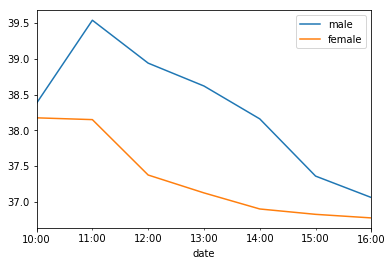

In [119]:
temps.plot();

Looks like we are on to something, pity this is not real data.

However, we didn't take the patients' condition into account yet. Let's check how many patients have a specific condition.

In [120]:
data[['patient', 'condition']] \
    .drop_duplicates() \
    .groupby('condition') \
    .count()

,patient
condition,
A,5
B,4
C,1


That doesn't seem right.  We have only 9 patients, but 10 conditions. Let's check condition C specifically.

In [121]:
data[data['condition'] == 'C']

,patient,dose,date,temperature,gender,condition
43,7,5.0,2012-10-02 12:00:00,39.8,M,C


It seems that patient 7 has condition C only at 12:00, but not at other times during the trial.  That must be a typo, so we correct it.

In [122]:
data[data['patient'] == 7]

,patient,dose,date,temperature,gender,condition
41,7,0.0,2012-10-02 10:00:00,39.5,M,B
42,7,10.0,2012-10-02 11:00:00,40.7,M,B
43,7,5.0,2012-10-02 12:00:00,39.8,M,C
44,7,8.0,2012-10-02 13:00:00,40.2,M,B
45,7,3.0,2012-10-02 14:00:00,38.3,M,B
46,7,3.0,2012-10-02 15:00:00,37.6,M,B
47,7,1.0,2012-10-02 16:00:00,37.3,M,B


In [123]:
data.at[43, 'condition'] = 'B'

Let's verify whether the data for patient 7 is consistent now.

In [124]:
data[data['patient'] == 7]

,patient,dose,date,temperature,gender,condition
41,7,0.0,2012-10-02 10:00:00,39.5,M,B
42,7,10.0,2012-10-02 11:00:00,40.7,M,B
43,7,5.0,2012-10-02 12:00:00,39.8,M,B
44,7,8.0,2012-10-02 13:00:00,40.2,M,B
45,7,3.0,2012-10-02 14:00:00,38.3,M,B
46,7,3.0,2012-10-02 15:00:00,37.6,M,B
47,7,1.0,2012-10-02 16:00:00,37.3,M,B


In [125]:
data[['patient', 'condition']] \
    .drop_duplicates() \
    .groupby('condition') \
    .count()

,patient
condition,
A,5
B,4


What is the distribution of the condition with respect to the patients's gender?

In [126]:
data[['patient', 'condition', 'gender']] \
    .drop_duplicates() \
    .groupby(('condition', 'gender')) \
    .count()

patient
condition gender         
A         F             2
          M             3
B         F             2
          M             2

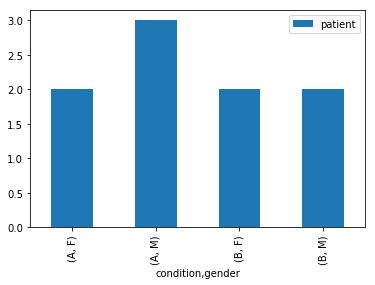

In [133]:
data[['patient', 'condition', 'gender']] \
    .drop_duplicates() \
    .groupby(('condition', 'gender')) \
    .count().plot.bar()

Let's create an extra column in the `DataFrame` that is categorical, and represents the status of the patients in terms of fever.

In [127]:
data['status'] = pd.cut(data.temperature,
                        bins=[35.5, 37.5, 39.5, 43.0],
                        labels=['normal', 'fever', 'high fever'])

In [128]:
data.head()

,patient,dose,date,temperature,gender,condition,status
0,1,0.0,2012-10-02 10:00:00,38.3,M,A,fever
1,1,2.0,2012-10-02 11:00:00,38.5,M,A,fever
2,1,2.0,2012-10-02 12:00:00,38.1,M,A,fever
3,1,2.0,2012-10-02 13:00:00,37.3,M,A,normal
4,1,0.0,2012-10-02 14:00:00,37.5,M,A,normal


In [129]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 7 columns):
patient        63 non-null int64
dose           61 non-null float64
date           63 non-null datetime64[ns]
temperature    61 non-null float64
gender         63 non-null object
condition      63 non-null object
status         61 non-null category
dtypes: category(1), datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 3.2+ KB


In [130]:
data.status.describe()

count        61
unique        3
top       fever
freq         30
Name: status, dtype: object

A similar query to the one we did before can now be done on the `status` attribute.

In [131]:
data.query('status == "high fever"')

,patient,dose,date,temperature,gender,condition,status
42,7,10.0,2012-10-02 11:00:00,40.7,M,B,high fever
43,7,5.0,2012-10-02 12:00:00,39.8,M,B,high fever
44,7,8.0,2012-10-02 13:00:00,40.2,M,B,high fever
57,9,12.0,2012-10-02 12:00:00,40.2,M,B,high fever


The patients with high fever are given by:

In [132]:
data[['patient', 'status']] \
    .query('status == "high fever"') \
    .drop_duplicates()['patient']

42    7
57    9
Name: patient, dtype: int64